<a href="https://colab.research.google.com/github/blhuillier/2025B_AstroDataAnalysis/blob/main/Notebooks/Chap_4_Least_Squares_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Download data from:
2. Plot $mu(z)$
3. we want to transfomr $\mu$ to $d_L$.  
  a. Estimate $\sigma_{d_L}$ with Error propagation formula (Jacobian).  
  b. with MC.


In [15]:
filecov = "https://raw.githubusercontent.com/PantheonPlusSH0ES/DataRelease/refs/heads/main/Pantheon%2B_Data/4_DISTANCES_AND_COVAR/Pantheon%2BSH0ES_STAT%2BSYS.cov"
filemu = "https://raw.githubusercontent.com/PantheonPlusSH0ES/DataRelease/refs/heads/main/Pantheon%2B_Data/4_DISTANCES_AND_COVAR/Pantheon%2BSH0ES.dat"


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pan = pd.read_csv(filemu, sep=r'\s+') # delim_whitespace=True
# cov = pd.read_csv(filecov, delim_whitespace=True
cov = np.loadtxt(filecov)
nsn = int(cov[0])
cov = np.reshape(cov[1:],(nsn,nsn))
print (cov.shape)



(1701, 1701)


In [16]:
pan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1701 entries, 0 to 1700
Data columns (total 47 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CID                   1701 non-null   object 
 1   IDSURVEY              1701 non-null   int64  
 2   zHD                   1701 non-null   float64
 3   zHDERR                1701 non-null   float64
 4   zCMB                  1701 non-null   float64
 5   zCMBERR               1701 non-null   float64
 6   zHEL                  1701 non-null   float64
 7   zHELERR               1701 non-null   float64
 8   m_b_corr              1701 non-null   float64
 9   m_b_corr_err_DIAG     1701 non-null   float64
 10  MU_SH0ES              1701 non-null   float64
 11  MU_SH0ES_ERR_DIAG     1701 non-null   float64
 12  CEPH_DIST             1701 non-null   float64
 13  IS_CALIBRATOR         1701 non-null   int64  
 14  USED_IN_SH0ES_HF      1701 non-null   int64  
 15  c                    

<ErrorbarContainer object of 3 artists>

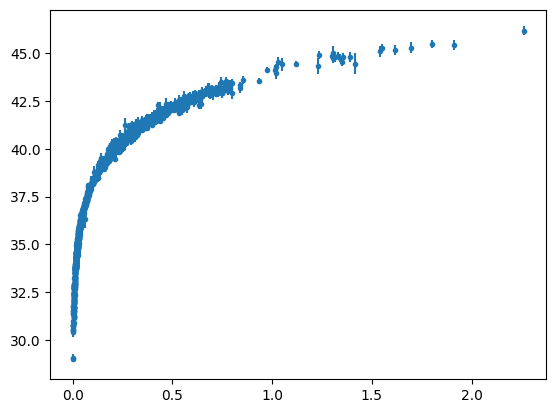

In [17]:
fig, ax = plt.subplots(1)
sigma_mu = np.sqrt(np.diag(cov))
ax.errorbar(pan['zHD'], pan['MU_SH0ES'], sigma_mu, ls='', marker='.')

In [21]:
mu = pan['MU_SH0ES'].values
dL = 10**(mu/5-5)
J = np.log(10)/5 * np.diag(dL)

cov_dL = J.T @ cov @ J

print (np.sqrt(np.diag(cov_dL)))


[5.17608826e-01 5.54311342e-01 1.59032227e+00 ... 1.17477631e+03
 1.45320393e+03 1.68408467e+03]


In [23]:
# MC:



#1. Generate mu_{MC,1}(z), mu_{MC,2}(z), ...., mu_{MC,N}(z) multivariate Gaussian distribution with
# expected value mu_th(z), covariance C_pantheon

#2. Estimate Expected value [d_L]
#3. Estimate Cov(d_L)




Pandas is a useful python library to deal with data: Let's take a look at the tutorial:

https://pandas.pydata.org/docs/user_guide/10min.html



# Exercise I. Ordinary Least Squares

We want to model a system such that
$$Y = f(X) = a X^2 + b X + c,$$
where $(a,b,c)$ are the parameter of the model.

1. Write the system as an ordinary least square problem

2. Generate $N$ points for $X_i\sim \mathcal U(0,1)$

3. Set $(a,b,c) = (1,-2,3)$, and generate the corresponding $Y_i = f(X_i) + \varepsilon$,
where $\varepsilon \simeq \mathcal{N}(0,0.5^2)$.

4. Overplot the true model and the realizations $(X_i,Y_i)$.

5. Calculate the OLS solution and find the best-fit parameters $(\hat a, \hat b, \hat c)$

(6. Redo the same thing assuming $\epsilon\sim\mathcal{N}(0,\mathop{\mathrm{diag}}(\sigma_i^2)$),
with $\sigma_i = 0.5 (1+X_i)$


# Exercise II. (From Feigelson & Babu)

1. Download the example QSO SDSS sample: https://astrostatistics.psu.edu/MSMA/datasets/SDSS_QSO.dat

2. You can use pandas to play with the data (I'll introduce it). The goal is to study the linear dependency of $z$-band on the $i$ band. It is not particularly physically interesting but at least you get to play with real data.

3. Select QSO with $18<i<22$ and fix values with $\sigma_z<0.01$ to 0.01. This prevents weird behaviours for abnormally small errors. You can also choose to remove QSO with $\sigma_z<0.01$.

4. Make a linear regression using the ordinary least square (ignore the errors in $z$.

5. Now let's consider the $z$-band error. Make a linear regression using the weighted least squares.



# Exercise III. (From Feidelson & Babu)

Fitting a Sersic Profile.
$$
\begin{align}
\mu(r) & = \mu_0 - 2.5 \log_{10} I(r)\\
\log_{10} I(r) & = \log_{10} I_e + b_n\left[\left(\frac r {r_e}\right)^{1/n}-1\right]\\
b_n & = -0.868n+0.142
\end{align}
$$
We can rewrite it as
$$
\begin{align}
\mu(r) = A-2.5 b_n\left[\left(\frac r {r_e}\right)^{1/n}-1\right]
\end{align}
$$


1. Download the NGC4472 data:  http://astrostatistics.psu.edu/MSMA/datasets/NGC4472_profile.dat

2. Plot the data

3. Plot the prediction $\mu(r;\theta)$ for different values of $\theta$. Calculate the corresponding
$$\chi^2 = \sum (\mu_i-\mu(r_i;A,n,r_e))^2$$

4. Plot $\chi^2(A=23,n,r_e)$

5. Fit the Sersic profile: find the non-linear least-square parameters

6. Plot the residuals

7. Same with http://astrostatistics.psu.edu/MSMA/datasets/NGC4406_profile.dat and http://astrostatistics.psu.edu/MSMA/datasets/NGC4551_profile.dat

